In [21]:
# imports: this cell will have all the imports used in this notebook
import random
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.stats import bernoulli
from bitstring import BitArray

# sklearn imports 
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split as split
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression

# importing the minmaxscaler to normalize data between 0 and 1
from sklearn.preprocessing import MinMaxScaler

# keres imports
from keras.layers import LSTM, Input, Dense, Dropout, Activation
from keras.models import Model
from keras.models import Sequential

# Deap for genetic algorithm imports
from deap import base, creator, tools, algorithms

# seeding to get reproducible results with Keras and numpy
from numpy.random import seed
import tensorflow

seed(1)
tensorflow.random.set_seed(2)

%matplotlib inline

In [22]:
# Use TeX fonts
plt.rc("text", usetex=False)
plt.rc('font', **{'family': 'serif', 'serif': ['cmr10']})
plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rc('font', size=15.0)
plt.rc('font', weight='normal')
plt.rc('legend', fontsize=12.0)
plt.rc('axes', grid=False) 
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [23]:
# read and convert csv data into a dataframe and print it out
df_inp = pd.read_csv("inputs_sample_m.csv")
df_inp.head(n=10)

,COR_SC 1131,COR_SC 1132,COR_CMT,COR_EDR,COR_EDR (LP),COR_ZP,DC Power Limit,COR_CHT,COR_LP,COR_SC 1141,SRV LAMDA
0,2293.356662,2789.402256,0.230395,0.005509,0.024595,0.139081,3.918165,16911.306560,1906.512535,0.224355,0.100424
1,2327.973792,2654.097438,0.463208,0.017686,0.001503,0.331455,7.090109,11464.346490,2583.577445,0.770091,0.100134
2,2229.495518,2728.877450,0.119571,0.030271,0.001139,0.219394,3.956615,16847.739940,2036.271861,0.437037,0.100794
3,2169.838177,2711.497422,0.325962,0.017823,0.005905,0.466482,6.396841,8032.071485,2540.804117,0.265412,0.107670
4,2454.066629,2416.023124,0.150077,0.004228,0.009376,0.343951,3.413674,18880.585550,2298.552144,0.233114,0.104237
5,2157.928603,2423.728807,0.158060,0.002022,0.016421,0.171284,5.237637,11540.942380,2780.718438,0.305795,0.103095
6,2175.022605,2556.160791,0.114612,0.025801,0.010504,0.245718,3.532934,5684.961075,1623.582479,0.574269,0.103027
7,2329.388487,2640.571851,0.228932,0.026381,0.022747,0.423525,5.335959,10794.111880,3243.410569,0.347614,0.104575
8,2335.912325,2560.934896,0.239971,0.033231,0.001561,0.244234,3.939197,8500.876974,2761.312180,0.792433,0.104122
9,2456.125236,2543.395349,0.117940,0.008857,0.001054,0.382875,3.188109,13004.319390,2439.381116,0.350448,0.100373


In [24]:
df_out = pd.read_csv("output_sample_m.csv")
df_out.head(n=10)

,H2,Temp,Press
0,32.265517,633.0,7360000.0
1,33.942989,671.0,7380000.0
2,37.661494,648.0,7400000.0
3,34.766782,649.0,7380000.0
4,28.771954,652.0,7380000.0
5,31.561494,638.0,7380000.0
6,34.642414,678.0,7380000.0
7,35.559195,672.0,7380000.0
8,40.568621,634.0,7380000.0
9,31.568046,641.0,7370000.0


array([[<Axes: title={'center': 'COR_SC 1131'}>,
        <Axes: title={'center': 'COR_SC 1132'}>,
        <Axes: title={'center': 'COR_CMT'}>],
       [<Axes: title={'center': 'COR_EDR'}>,
        <Axes: title={'center': 'COR_EDR (LP)'}>,
        <Axes: title={'center': 'COR_ZP'}>],
       [<Axes: title={'center': 'DC Power Limit'}>,
        <Axes: title={'center': 'COR_CHT'}>,
        <Axes: title={'center': 'COR_LP'}>],
       [<Axes: title={'center': 'COR_SC 1141'}>,
        <Axes: title={'center': 'SRV LAMDA'}>, <Axes: >]], dtype=object)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

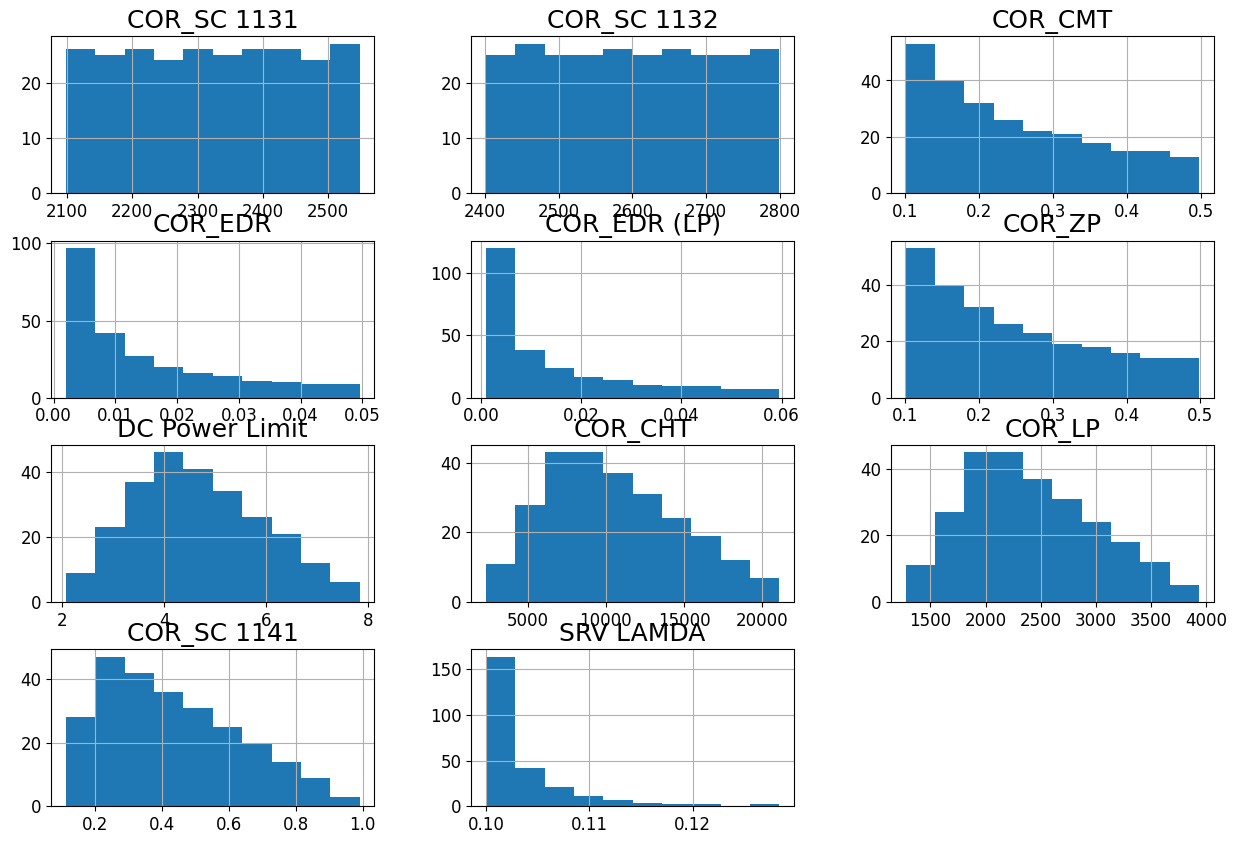

In [25]:
lst = list(df_inp.columns)
df_inp[lst].hist(figsize=(15,10))

In [26]:
%matplotlib inline
from subprocess import check_output
%config Completer.use_jedi = False

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import  mean_squared_error, r2_score

In [27]:
distributions = [
    ('Unscaled data', X),
    ('Data after standard scaling',
        StandardScaler().fit_transform(X)),
    ('Data after min-max scaling',
        MinMaxScaler().fit_transform(X)),
    ('Data after max-abs scaling',
        MaxAbsScaler().fit_transform(X)),
    ('Data after robust scaling',
        RobustScaler(quantile_range=(25, 75)).fit_transform(X)),
    ('Data after power transformation (Yeo-Johnson)',
     PowerTransformer(method='yeo-johnson').fit_transform(X)),
#     ('Data after power transformation (Box-Cox)',
#      PowerTransformer(method='box-cox').fit_transform(X)),
    ('Data after quantile transformation (uniform pdf)',
        QuantileTransformer(output_distribution='uniform')
        .fit_transform(X)),
    ('Data after quantile transformation (gaussian pdf)',
        QuantileTransformer(output_distribution='normal')
        .fit_transform(X)),
    ('Data after sample-wise L2 normalizing',
        Normalizer().fit_transform(X)),
]

# scale the output between 0 and 1 for the colorbar
y = minmax_scale(y_opt)

# X_train, X_test, y_train, y_test = data_preprocess(X,y)
item_idx = 1 
title, X = distributions[item_idx]
print(title)

NameError: name 'X' is not defined

Using GA

In [ ]:
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Integer, Categorical, Continuous
from sklearn_genetic.plots import plot_fitness_evolution, plot_search_space
from sklearn_genetic.callbacks import LogbookSaver, ProgressBar
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
# from sklearn.gaussian_process.kernels import RBF,  DotProduct, ConstantKernel as C
pipe = RandomForestRegressor()

param_grid = {'min_weight_fraction_leaf': Continuous(0.01, 0.5, distribution='log-uniform'),
              'bootstrap': Categorical([True, False]),
              'max_depth': Integer(2, 30), 
              'max_leaf_nodes': Integer(2, 35), 
              'n_estimators': Integer(100, 300)}

# Define the GASearchCV options
evolved_estimator = GASearchCV(
    estimator=pipe,
    cv=10,
    scoring="r2",
    population_size=15,
    generations=20,
    tournament_size=3,
    elitism=True,
    keep_top_k=4,
    crossover_probability=0.9,
    mutation_probability=0.05,
    param_grid=param_grid,
#     param_grid=None,
    criteria="max",
    algorithm="eaMuCommaLambda",
    n_jobs=-1)

#Optionally, create some Callbacks
callbacks = [LogbookSaver(checkpoint_path="./logbook.pkl"), ProgressBar()]

# Fit the model and see some results
evolved_estimator.fit(X_train, y_train, callbacks=callbacks)
y_predict_ga = evolved_estimator.predict(X_test)
r_squared = r2_score(y_test, y_predict_ga)

print(evolved_estimator.best_params_)
print("r-squared: ", "{:.2f}".format(r_squared))
print("Best k solutions: ", evolved_estimator.hof)

In [ ]:
plot = plot_fitness_evolution(evolved_estimator, metric="fitness")

In [ ]:
plt.rc("text", usetex=False)
plot_search_space(evolved_estimator)

In [ ]:
plt.figure(figsize=[6,5])
plt.scatter(y_test, y_predict_ga, s=90)
plt.xlim(left=0.86)
plt.ylim(bottom=0.88, top=0.96)

In [ ]:
plt.rc("text", usetex=True)
import scipy 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[8,5], dpi=80)

fig.suptitle(r'Model Performance of Hydrogen')
ax1.scatter(y_test, y_predict_ga, s=120, alpha=0.5)
ax1.set_xlim(left=0.86)
ax1.set_ylim(bottom=0.88, top=0.96)
ax1.set_xlabel(r'Scaled Actual Output')
ax1.set_ylabel(r'Scaled Predicted Output')
ax1.set_title(r'$R^2 = {:.4g}$'.format(r2_score(y_test, y_predict_ga)))

# best fit of data
data_res = y_test - y_predict_ga 
(mu, sigma) = norm.fit(data_res[data_res > -0.08])

# the histogram of the data
n, bins, patches =  ax2.hist(y_test - y_predict_ga, 30, density=1, alpha=0.5)

# add a 'best fit' line
best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
l = plt.plot(bins, best_fit_line, 'r--', linewidth=2)


ax2.set_xlim(left=-0.08)
ax2.set_xlabel(r'Residual')
ax2.set_ylabel(r'Frequency')
ax2.set_title(r'$\sigma = {:.4f}$'.format(mean_squared_error(y_test, y_predict_ga, squared=False)))

fig.tight_layout()

MLP

In [ ]:
from sklearn import neural_network

pipe = neural_network.MLPRegressor()

param_grid = {
#     'min_weight_fraction_leaf': Continuous(0.01, 0.5, distribution='log-uniform'),
#               'bootstrap': Categorical([True, False]),
#               'max_depth': Integer(2, 30), 
#               'max_leaf_nodes': Integer(2, 35), 
#               'n_estimators': Integer(100, 300)             
          'solver': Categorical(['lbfgs', 'sgd', 'adam']),
          'max_iter': Integer(500,1500),
          'alpha': Continuous(10.0**(-7), 10.0**(-1), distribution='log-uniform'),
          'hidden_layer_sizes': Integer(5, 12),
          'random_state':Integer(0, 9)
             
             }

# Define the GASearchCV options
evolved_estimator = GASearchCV(
    estimator=pipe,
    cv=10,
    scoring="r2",
    population_size=15,
    generations=20,
    tournament_size=3,
    elitism=True,
    keep_top_k=4,
    crossover_probability=0.9,
    mutation_probability=0.05,
    param_grid=param_grid,
#     param_grid=None,
    criteria="max",
    algorithm="eaMuCommaLambda",
    n_jobs=-1)

#Optionally, create some Callbacks
callbacks = [LogbookSaver(checkpoint_path="./logbook.pkl"), ProgressBar()]

# Fit the model and see some results
evolved_estimator.fit(X_train, y_train, callbacks=callbacks)
y_predict_ga = evolved_estimator.predict(X_test)
r_squared = r2_score(y_test, y_predict_ga)

print(evolved_estimator.best_params_)
print("r-squared: ", "{:.2f}".format(r_squared))
print("Best k solutions: ", evolved_estimator.hof)

In [ ]:
plot = plot_fitness_evolution(evolved_estimator, metric="fitness")

In [ ]:
plt.rc("text", usetex=False)
plot_search_space(evolved_estimator)

In [ ]:
plt.figure(figsize=[6,5])
plt.scatter(y_test, y_predict_ga, s=90)
plt.xlim(left=0.86)
plt.ylim(bottom=0.88, top=0.96)

In [ ]:
plt.rc("text", usetex=False)
import scipy 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[8,5], dpi=80)

fig.suptitle(r'Model Performance of Hydrogen')
ax1.scatter(y_test, y_predict_ga, s=120, alpha=0.5)
ax1.set_xlim(left=0.86)
ax1.set_ylim(bottom=0.88, top=0.96)
ax1.set_xlabel(r'Scaled Actual Output')
ax1.set_ylabel(r'Scaled Predicted Output')
ax1.set_title(r'$R^2 = {:.4g}$'.format(r2_score(y_test, y_predict_ga)))

# best fit of data
data_res = y_test - y_predict_ga 
(mu, sigma) = norm.fit(data_res[data_res > -0.08])

# the histogram of the data
n, bins, patches =  ax2.hist(y_test - y_predict_ga, 30, density=1, alpha=0.5)

# add a 'best fit' line
best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
l = plt.plot(bins, best_fit_line, 'r--', linewidth=2)


ax2.set_xlim(left=-0.08)
ax2.set_xlabel(r'Residual')
ax2.set_ylabel(r'Frequency')
ax2.set_title(r'$\sigma = {:.4f}$'.format(mean_squared_error(y_test, y_predict_ga, squared=False)))

fig.tight_layout()

In [ ]:
from sklearn.linear_model import BayesianRidge

param_grid = {'n_iter': Integer(300, 500),
              'tol': Continuous(0.0001, 0.1),
              'alpha_1': Continuous(1.0e-7, 1e-1),
              'alpha_2': Continuous(1.0e-7, 1e-1),
              'lambda_1': Continuous(1.0e-7, 1e-1),
              'lambda_2': Continuous(1.0e-7, 1e-1),
              'normalize': Categorical([False, True])}



pipe = BayesianRidge()

# param_grid = {'min_weight_fraction_leaf': Continuous(0.01, 0.5, distribution='log-uniform'),
#               'bootstrap': Categorical([True, False]),
#               'max_depth': Integer(2, 30), 
#               'max_leaf_nodes': Integer(2, 35), 
#               'n_estimators': Integer(100, 300)}
# Create the CV strategy and define the param grid
cv = KFold(n_splits=10, shuffle=True)

# Define the GASearchCV options
evolved_estimator = GASearchCV(
    estimator=pipe,
    cv=cv,
    scoring="r2",
    population_size=15,
    generations=20,
    tournament_size=3,
    elitism=True,
    keep_top_k=4,
    crossover_probability=0.9,
    mutation_probability=0.05,
    param_grid=param_grid,
#     param_grid=None,
    criteria="max",
    algorithm="eaMuCommaLambda",
    n_jobs=-1)

#Optionally, create some Callbacks
callbacks = [LogbookSaver(checkpoint_path="./logbook.pkl"), ProgressBar()]

# Fit the model and see some results
evolved_estimator.fit(X_train, y_train, callbacks=callbacks)
y_predict_ga = evolved_estimator.predict(X_test)
r_squared = r2_score(y_test, y_predict_ga)

print(evolved_estimator.best_params_)
print("r-squared: ", "{:.2f}".format(r_squared))
print("Best k solutions: ", evolved_estimator.hof)

In [ ]:
plot = plot_fitness_evolution(evolved_estimator, metric="fitness")

In [ ]:
plt.rc("text", usetex=False)
plot_search_space(evolved_estimator)

In [ ]:
plt.figure(figsize=[6,5])
plt.scatter(y_test, y_predict_ga, s=90)
plt.xlim(left=0.86)
plt.ylim(bottom=0.88, top=0.96)

In [ ]:
plt.rc("text", usetex=False)
import scipy 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[8,5], dpi=80)

fig.suptitle(r'Model Performance of Hydrogen')
ax1.scatter(y_test, y_predict_ga, s=120, alpha=0.5)
ax1.set_xlim(left=0.86)
ax1.set_ylim(bottom=0.88, top=0.96)
ax1.set_xlabel(r'Scaled Actual Output')
ax1.set_ylabel(r'Scaled Predicted Output')
ax1.set_title(r'$R^2 = {:.4g}$'.format(r2_score(y_test, y_predict_ga)))

# best fit of data
data_res = y_test - y_predict_ga 
(mu, sigma) = norm.fit(data_res[data_res > -0.08])

# the histogram of the data
n, bins, patches =  ax2.hist(y_test - y_predict_ga, 30, density=1, alpha=0.5)

# add a 'best fit' line
best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
l = plt.plot(bins, best_fit_line, 'r--', linewidth=2)


ax2.set_xlim(left=-0.08)
ax2.set_xlabel(r'Residual')
ax2.set_ylabel(r'Frequency')
ax2.set_title(r'$\sigma = {:.4f}$'.format(mean_squared_error(y_test, y_predict_ga, squared=False)))

fig.tight_layout()